In [1]:
import os
import pickle
import copy

import torch
import torch_geometric
import numpy as np
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glycowork.glycan_data.loader import lib

from glycontact.visualize import extract_torsion_angles
from glycontact.learning import create_dataset, VonMisesSweetNet, train_model

# Seed everything for reproducibility
torch_geometric.seed_everything(42)

/home/rjo21/miniconda3/envs/glycontact/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sh: cd-hit: command not found
sh: cd-hit-est: command not found
sh: diamond: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mash: command not found
sh: foldseek: command not found
sh: TMalign: command not found


In [2]:
if not os.path.exists("conformer_split.pkl"):
    train, test = create_dataset()
    with open("conformer_split.pkl", "wb") as f:
        pickle.dump((train, test), f)
else:
    with open("conformer_split.pkl", "rb") as f:
        train, test = pickle.load(f)

In [3]:
model = VonMisesSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
optim = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)

In [4]:
metrics = train_model(
    model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in test], batch_size=64),
    },
    optim,
    scheduler,
    num_epochs=100,
)

Epoch 0/99
----------
train Loss: 7.6878 Phi: 0.9868 Psi: 1.2913 SASA: 221.8738 Flex: 1.7118
val Loss: 7.9456 Phi: 1.4691 Psi: 1.0513 SASA: 219.9747 Flex: 1.7590

Epoch 1/99
----------
train Loss: 6.6005 Phi: 0.5993 Psi: 1.0381 SASA: 220.1507 Flex: 1.2939
val Loss: 6.7637 Phi: 0.4863 Psi: 1.0227 SASA: 218.1232 Flex: 1.6193

Epoch 2/99
----------
train Loss: 6.2282 Phi: 0.4196 Psi: 0.9335 SASA: 218.2338 Flex: 1.2378
val Loss: 6.7559 Phi: 0.6350 Psi: 0.8810 SASA: 217.1378 Flex: 1.6210

Epoch 3/99
----------
train Loss: 6.0479 Phi: 0.3490 Psi: 0.8805 SASA: 216.2323 Flex: 1.2146
val Loss: 6.3715 Phi: 0.3459 Psi: 0.8331 SASA: 214.5580 Flex: 1.6165

Epoch 4/99
----------
train Loss: 5.8927 Phi: 0.2827 Psi: 0.8498 SASA: 214.0416 Flex: 1.1928
val Loss: 6.3191 Phi: 0.3612 Psi: 0.8320 SASA: 212.6196 Flex: 1.5821

Epoch 5/99
----------
train Loss: 5.7522 Phi: 0.2397 Psi: 0.8094 SASA: 211.7063 Flex: 1.1747
val Loss: 6.1204 Phi: 0.2873 Psi: 0.8007 SASA: 210.8213 Flex: 1.5187

Epoch 6/99
----------


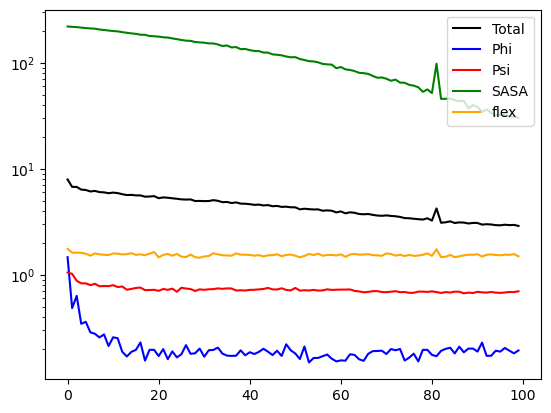

In [5]:
plt.plot(metrics["val"]["loss"], c="black", label="Total")
plt.plot(metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()

plt.show()

In [6]:
def sample_angle(weights, mus, kappas):
    idx = np.random.choice(len(weights), p=weights)
    mu = (mus[idx] * np.pi / 180.0) % (2 * np.pi)
    if mu > np.pi:
        mu -= 2 * np.pi
    angle_sample = torch.distributions.von_mises.VonMises(mu, kappas[idx] + 1e-10).sample()
    angle_sample = angle_sample * 180.0 / np.pi
    return angle_sample


def sample_from_model(model, structures, count=10):
    """
    Sample from the model using the provided structures
    Args:
        model: The trained model
        structures: List of structure graphs
    Returns:
        List of sampled angles
    """
    model.eval()
    sampled_structures = []
    with torch.no_grad():
        for i, (data, graph) in enumerate(structures):
            print(f"\r{i + 1} / {len(structures)}", end="")
            for _ in range(count):
                weights_logits_von_mises, mus_von_mises, kappas_von_mises, sasa_pred, flex_pred = model(data.x.to("cuda"), data.edge_index.to("cuda"))
                weights_von_mises = torch.nn.functional.softmax(weights_logits_von_mises, dim=2).cpu().numpy()

                G = copy.deepcopy(graph)
                for n, node in enumerate(G.nodes):
                    if "phi_angle" in G.nodes[node]:
                        G.nodes[node]["phi_angle"] = sample_angle(weights_von_mises[n, 0], mus_von_mises[n, 0], kappas_von_mises[n, 0]).item()
                        G.nodes[node]["psi_angle"] = sample_angle(weights_von_mises[n, 1], mus_von_mises[n, 1], kappas_von_mises[n, 1]).item()
                    elif "SASA" in G.nodes[node]:
                        G.nodes[node]["SASA"] = sasa_pred[n].item()
                        G.nodes[node]["flexibility"] = flex_pred[n].item()
                sampled_structures.append(G)
    return sampled_structures


# x = list(sorted([x for x in test if "Neu5Ac(a2-3)Gal" in x[0].iupac], key=lambda x: len(x[0].iupac)))[10]
# print(x[1].nodes(data=True))
# sample_from_model(model, [x], count=1)[0].nodes(data=True)
samples = sample_from_model(model, test)

1143 / 1143

In [7]:
def ramachandran_plot(
        disaccharide: str, 
        structure_graphs: list[nx.DiGraph],
        density: bool = True,
        ax: plt.Axes = None,
        mode: str = None,
        split: str = None,
        conf: str = None,
) -> plt.Figure:
    """Generate a Ramachandran plot for a specific disaccharide linkage.
    Args:
    disaccharide: String representing the disaccharide (e.g., "Fuc(a1-2)Gal")
    structure_graphs: Dictionary of glycan structure graphs
    density: Whether to show density contours (default: True)
    filepath: Path to save the figure (optional)
    Returns:
    Matplotlib figure object
    """
    phi_angles, psi_angles = extract_torsion_angles(disaccharide, dict(enumerate(structure_graphs)))
    if not phi_angles or not psi_angles:
        raise ValueError(f"No torsion angles found for disaccharide: {disaccharide}")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create density contours if requested
    if density and len(phi_angles) > 3:
        # Calculate the point density
        xy = np.vstack([phi_angles, psi_angles])
        z = stats.gaussian_kde(xy)(xy)
        # Sort the points by density for better visualization
        idx = z.argsort()
        x_sorted, y_sorted, z_sorted = np.array(phi_angles)[idx], np.array(psi_angles)[idx], z[idx]
        # Clear the previous plot and redraw with density coloring
        ax.clear()
        scatter = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=30, cmap='viridis')
        plt.colorbar(scatter, ax=ax, label='Density')
    else:
        # Create the scatter plot
        ax.scatter(phi_angles, psi_angles, alpha=0.7, s=30, c='blue', edgecolor='white')

    # Set plot limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi (°)')
    ax.set_ylabel('Psi (°)')
    ax.set_title(f'Ramachandran Plot for {(mode + " ") if mode else ""}{disaccharide} angles{(" in " + split) if split else ""} {conf} conformers')
    # Add grid lines
    ax.grid(alpha=0.3)
    # Add the origin lines
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    # Add statistics
    stats_text = (
        f"n = {len(phi_angles)}\n"
        f"Mean φ = {np.mean(phi_angles):.1f}° ± {np.std(phi_angles):.1f}°\n"
        f"Mean ψ = {np.mean(psi_angles):.1f}° ± {np.std(psi_angles):.1f}°"
    )
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

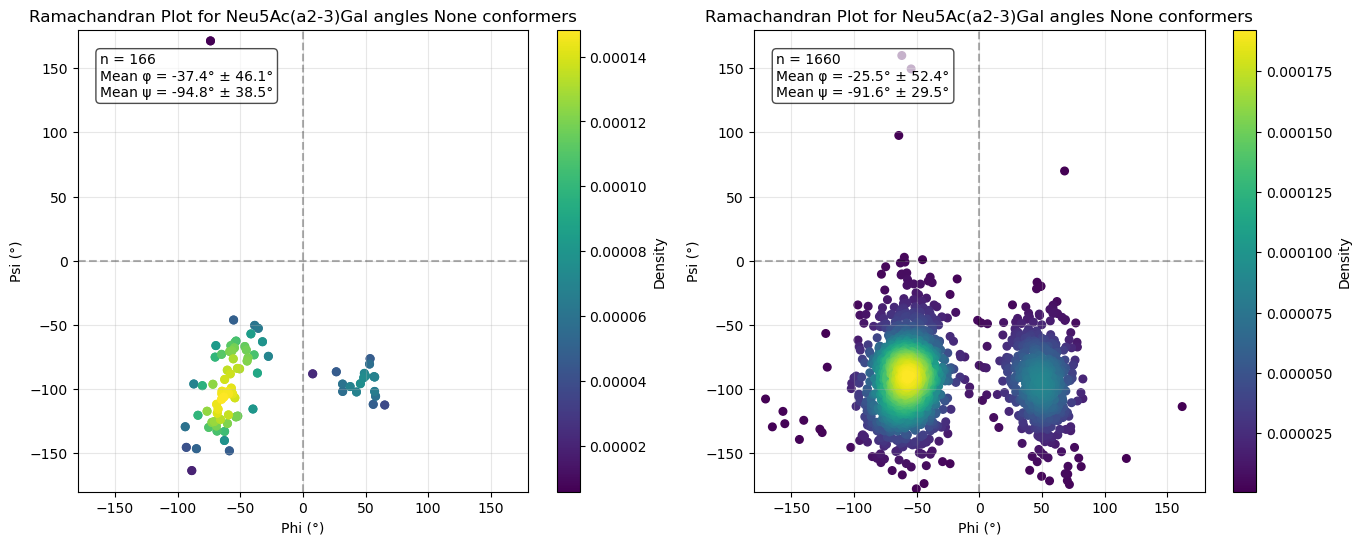

In [8]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=[x[1] for x in test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=samples, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

0.9178186353167784


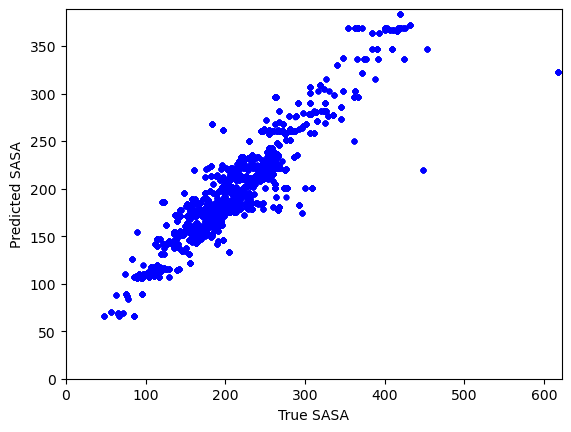

In [9]:
def plot_value_distributions(
        true_graphs: list[nx.DiGraph],
        pred_graphs: list[nx.DiGraph],
        value_name: str,
):
    true_values, pred_values = [], []
    for true_graph, pred_graph in zip(true_graphs, pred_graphs):
        for n in true_graph.nodes:
            if value_name in true_graph.nodes[n] and value_name in pred_graph.nodes[n]:
                true_values.append(true_graph.nodes[n][value_name])
                pred_values.append(pred_graph.nodes[n][value_name])
    
    plt.scatter(true_values, pred_values, s=10, marker="o", c="blue")
    print(np.corrcoef(true_values, pred_values)[0, 1])
    plt.xlim(0, min(5 + max(true_values), 1.2 * max(true_values)))
    plt.ylim(0, min(5 + max(pred_values), 1.2 * max(pred_values)))
    plt.xlabel(f"True {value_name}")
    plt.ylabel(f"Predicted {value_name}")

plot_value_distributions(
    [t[1] for t in test], 
    [samples[x] for x in range(0, len(samples), 10)],
    value_name="SASA",
)

0.5130991755206483


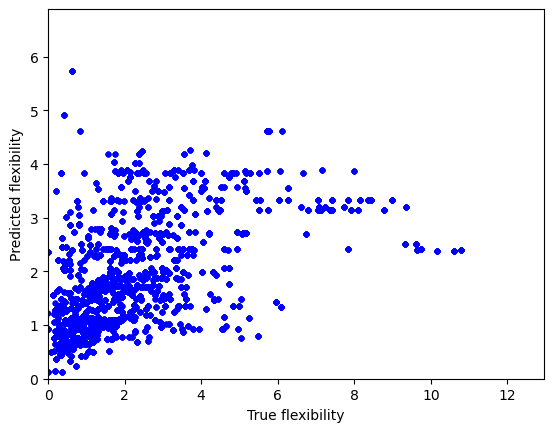

In [10]:
plot_value_distributions(
    [t[1] for t in test], 
    [samples[x] for x in range(0, len(samples), 10)],
    value_name="flexibility",
)